In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from utils import mnist_reader
import torch 
import torch.nn as nn
import os
import shutil
import matplotlib.image as mpimg
import time
import gc

In [3]:

# improve the ploting style
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 18
rcParams['mathtext.fontset'] = 'stix'

In [4]:
dtype = torch.float32

# Importation des données
x_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
x_valid, y_valid = mnist_reader.load_mnist('data/fashion', kind='t10k')
x_train, y_train_raw, x_valid, y_valid_raw = torch.tensor(x_train, dtype=dtype), torch.tensor(y_train, dtype=dtype), torch.tensor(x_valid, dtype=dtype), torch.tensor(y_valid,dtype=dtype)

# Modification du format des données shape (n_data,1) -> (n_data, n_classes)
y_train = torch.zeros(y_train_raw.shape[0], 10)
for i,y in enumerate(y_train_raw):
    j = int(y.item())
    y_train[i,j] = 1

y_valid = torch.zeros(y_valid_raw.shape[0], 10)
for i,y in enumerate(y_valid_raw):
    j = int(y.item())
    y_valid[i,j] = 1 
print(y_train.shape, y_valid.shape)

number_of_classes_reduction = False
class_binary_reduction = False


# Binary reduction of the classes # To avoid using softmax, we regroup classes in two classes
if class_binary_reduction :
    determination_des_classes = True
    if determination_des_classes :
        # Determination des classes
        class_list = []
        class_index = 0
        for i in range (x_train.shape[0]):
            if y_train[i, class_index] == 1:
                class_list.append(x_train[i])
                class_index += 1
            if len(class_list) == len(y_train[0]):
                break
            
        # For square images
        class_list = [x.reshape(int(np.sqrt(len(x))),int(np.sqrt(len(x)))) for x in class_list]
        for i, x in enumerate(class_list) :
            plt.subplot(2, len(class_list)//2+1, i+1)
            plt.imshow(x, cmap='gray')
            plt.xticks([])
            plt.yticks([])
        plt.show()
            
    classe1 = [0, 2, 4]
    classe2 = [5, 7, 9]

    # Création des masques pour les échantillons appartenant à ces classes
    mask_classe1_train = y_train[:, classe1].sum(dim=1) > 0  # True si appartient à classe1
    mask_classe2_train = y_train[:, classe2].sum(dim=1) > 0  # True si appartient à classe2
    
    mask_classe1_valid = y_valid[:, classe1].sum(dim=1) > 0
    mask_classe2_valid = y_valid[:, classe2].sum(dim=1) > 0
    
    # Filtrage des exemples concernés
    mask_train = torch.logical_or(mask_classe1_train, mask_classe2_train)
    mask_valid = torch.logical_or(mask_classe1_valid, mask_classe2_valid)
    x_train, y_train = x_train[mask_train], y_train[mask_train]
    x_valid, y_valid = x_valid[mask_valid], y_valid[mask_valid]

    # Création du vecteur de labels binaires (1 pour classe1, 0 pour classe2)
    y_train = (y_train[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
    y_valid = (y_valid[:, classe1].sum(dim=1) > 0).to(dtype).unsqueeze(1)
    
    # Avec tanh
    
    # x_train = 2*(x_train-0.5)
    # y_train = 2*(y_train-0.5)
    # x_valid = 2*(x_valid-0.5)
    # y_valid = 2*(y_valid-0.5)

    print(x_train.shape, y_train.shape, y_train[0:10], x_valid.shape, y_valid.shape)
    
if number_of_classes_reduction:
    number_of_classes = 5
    classes = torch.linspace(0,number_of_classes-1, number_of_classes, dtype = int)
    mask_train , mask_valid = y_train[:,classes].sum(1) > 0, y_valid[:,classes].sum(1) > 0
    print(mask_train.shape)
    x_train, y_train = x_train[mask_train], y_train[mask_train][:, classes]
    x_valid, y_valid = x_valid[mask_valid], y_valid[mask_valid][:, classes]
    
    

torch.Size([60000, 10]) torch.Size([10000, 10])


In [18]:
dtype = torch.float32

# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# else :
#     device = torch.device("cpu")
# print("Computing on : ", device)

device = torch.device("cpu")
print("Computing on : ", device)

def ReLU(x):
    return torch.max(torch.tensor(0).to(device),x)

def ReLU_derivative(x):
    return (x>0).type(dtype).to(device)

def softmax_derivative(s):
    """
    s : Tensor de shape (n_batch, num_classes), déjà softmaxé
    Renvoie : Tensor de shape (n_batch, num_classes, num_classes) contenant la jacobienne de softmax pour chaque échantillon
    """
    s = s.to(device)
    n, C = s.shape
    jacobians = torch.zeros(n, C, C, dtype=s.dtype).to(device) # Initialisation du tenseur Jacobien (n_batch, num_classes, num_classes) => (i,j,k) = dérivée de softmax au logit j du ième batch par rapport au logit k du même batch
    for i in range(n):  # Pour chaque échantillon du batch, on calcule la jacobienne de softmax
        si = s[i].unsqueeze(1)  # shape (C, 1) # vecteur softmax(logits) pour la i-ème donnée du batch
        jacobians[i] = torch.diagflat(si) - torch.mm(si,si.t()) # calcul de la jacobienne (matrice des dérivées croisées) de softmax au point z_i = vect(logits_i) # shape (C, C) -> Indice du Jacobien : lignes, Indice des logits : colonnes
    return jacobians

def sigmoid(x):
    return 1/(1+torch.exp(-x))

def sigmoid_derivative(x):
    return torch.exp(-x)/((1 + torch.exp(-x))**2)

def tanh_derivative(x):
    return (1 - (torch.tanh(x)**2)).to(device)

class two_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,number_of_classes,lr=1e-3, reg1 = 0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 100):
        """
        Constructor of the two-layer neural network class.
        """
        super(two_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        self.observation_by_class = False
        
        # Initializing layers and bias        
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(number_of_classes, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        self.classes_accuracies_trajectories = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        output = self.softmax(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1=0, reg2=0, eps_init=1, fraction_batch=0.01, observation_rate = 100, train_layer_1 = True, train_layer_2 = True, observation_by_class = False):
        
        # Initializing the training chronometer
        start = time.time()
        unwanted_time = 0
        
        # Initializing training parameters
        self.architecture = "2 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) 
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.observation_by_class = observation_by_class
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        # Moving training and validation datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        
        for i in range(N_iterations):
            # Sélection un lot de données aléatoires parmis les données d'entrainement 
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                if observation_by_class :
                    accuracy_by_class = []
                    for classe in range(self.number_of_classes): 
                        correct_class_pred = ((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)) & (torch.argmax(y_valid, dim=1) == classe)).sum()
                        total_class_data = (torch.argmax(y_valid, dim=1) == classe).sum()
                        class_accuracy = correct_class_pred/total_class_data
                        accuracy_by_class.append(class_accuracy.numpy())
                    self.classes_accuracies_trajectories.append(accuracy_by_class)  
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item(), 'Accuracies by class', accuracy_by_class)
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
                
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = output - y_minibatch; grad_output = grad_output.to(dtype)
            grad_z2 = torch.einsum('noz, no->nz', softmax_derivative(output), grad_output); grad_z2  = grad_z2.to(dtype) # shape(n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h1 = torch.mm(grad_z2, self.W2); grad_h1  = grad_h1.to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1); grad_z1  = grad_z1.to(dtype) # shape (n_data, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            del x_minibatch, y_minibatch, output, z2, h1, z1, grad_output, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2
            gc.collect()
        
        # Calcul de la durée de l'entraînement    
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
   
class three_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, number_of_classes,lr=0.01, reg1 =0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10):
        """
        Constructor of the three-layer neural network class.
        """
        super(three_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.observation_by_class = False
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(number_of_classes, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        self.classes_accuracies_trajectories = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        h2 = ReLU(z2) # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t()
        output = self.softmax(z3) # output layer # shape (n_data, number_of_classes)
        return output, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True, observation_by_class = False):
        
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch)
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
       
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Calcul de la prédiction
            output, z3, h2, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                if observation_by_class :
                    accuracy_by_class = []
                    for classe in range(self.number_of_classes): 
                        correct_class_pred = ((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)) & (torch.argmax(y_valid, dim=1) == classe)).sum()
                        total_class_data = (torch.argmax(y_valid, dim=1) == classe).sum()
                        class_accuracy = correct_class_pred/total_class_data
                        accuracy_by_class.append(class_accuracy.numpy())
                    self.classes_accuracies_trajectories.append(accuracy_by_class)  
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item(), 'Accuracies by class', accuracy_by_class)
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)
            grad_z3 = (torch.einsum('no,noz->nz',grad_output,softmax_derivative(output))).to(dtype) # shape (n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            del x_minibatch, y_minibatch, output, z3, h2, z2, h1, z1, grad_output, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3
            gc.collect()
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done"

class binary_classification_two_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,lr=1e-3, reg1 = 0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 100):
        """
        Constructor of the two-layer neural network class.
        """
        super(binary_classification_two_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        # Initializing layers and bias        
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(1, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(1,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        output = torch.sigmoid(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1=0, reg2=0, eps_init=1, fraction_batch=0.01, observation_rate = 100, train_layer_1 = True, train_layer_2 = True):
        # Initializing the training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "2 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) 
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        # Moving training and validation datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)
        
        for i in range(N_iterations):
            # Sélection un lot de données aléatoires parmis les données d'entrainement 
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            #print(output[0:5], z2[0:5], h1[0:5], z1[0:5])
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                print("Output", output[20:22])
                training_loss = torch.mean(0.5*(output - y_minibatch)**2)
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
                
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = output - y_minibatch; grad_output = grad_output.to(dtype)
            grad_z2 = grad_output*sigmoid_derivative(z2); grad_z2  = grad_z2.to(dtype) # shape(n_data, 1)
            grad_h1 = torch.mm(grad_z2, self.W2); grad_h1  = grad_h1.to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1); grad_z1  = grad_z1.to(dtype) # shape (n_data, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            
            if i == 1000:
                break
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            del x_minibatch, y_minibatch, output, z2, h1, z1, grad_output, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2
            gc.collect()
        
        # Calcul de la durée de l'entraînement    
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
    
class binary_classification_three_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, lr=0.01, reg1 =0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10):
        """
        Constructor of the three-layer neural network class.
        """
        super(binary_classification_three_layer_NN,self).__init__()
        # Initialisation des propriétés du réseau
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        
        # Initialisation de la propriété durée d'entrainement
        self.training_time = 0
        
        # Initialisation des couches et des biais du réseau
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(1, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(1,1,dtype=dtype)-1)
        
        # Moving to device 
        self.W1 = self.W1.to(device)
        self.W2 = self.W2.to(device)
        self.W3 = self.W3.to(device)
        self.b1 = self.b1.to(device)
        self.b2 = self.b2.to(device)
        self.b3 = self.b3.to(device)
        
        # Initializing Softmax
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        
        #Initializing losses and accuracies during training list
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, hidden_2_size ) # logits layer 2
        h2 = ReLU(z2) # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t() # shape (n_data, 1)
        output = sigmoid(z3) # output layer # shape (n_data, 1)
        return output, z3, h2, z2, h1, z1
    
    def train_layers(self, x_train, y_train, x_valid, y_valid, kappa = 2, lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True):
        # Initializing training chronometer
        start = time.time()
        unwanted_time = 0
        # Initializing training parameters
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - kappa = " + str(kappa) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch)
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        # Moving input datas to device
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        x_valid = x_valid.to(device)
        y_valid = y_valid.to(device)        
        # Initializing the number of training iterations 
        N_datas = self.input_dimension**(kappa)/self.fraction_batch # Number of datas that we want to use for the training
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_iterations = int(N_datas/minibatch_size)
        print(f"For kappa = {kappa}, the number of datas used for the training is {N_datas} and the number of iterations is {N_iterations}.")
        
        for i in range(N_iterations):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Calcul de la prédiction
            output, z3, h2, z2, h1, z1 = self.forward(x_minibatch)
            
            # Suivi de l'apprentissage # l'échantillonnage dépend d'observation_rate
            if i % self.observation_rate == 0:    
                unwanted_time_begin = time.time() # Pour soustraire le temps lié à la sauvegarde des données d'apprentissage au temps d'entrainement
                # Calcul des losses et de l'accuracy et ajout aux trajectoires
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean(((self.forward(x_valid)[0] > 0.5).to(dtype) == y_valid).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                # Soustraction du temps de sauvegarde
                unwanted_time += time.time() - unwanted_time_begin 
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            
            # Calcul des gradients
            grad_output = (output - y_minibatch).to(dtype)
            grad_z3 = grad_output*sigmoid_derivative(z3).to(dtype) # shape (n_data, 1) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = (torch.mm(grad_z3, self.W3)).to(dtype) # shape (n_data, hidden_2_size)
            grad_z2 = (grad_h2*ReLU_derivative(z2)).to(dtype) # shape(n_data, hidden_2_size)         
            grad_h1 = (torch.mm(grad_z2, self.W2)).to(dtype)  # shape (n_data, hidden_1_size)
            grad_z1 = (grad_h1*ReLU_derivative(z1)).to(dtype) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = (torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0]).to(dtype) # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = (torch.mean(grad_z1, dim=0).unsqueeze(1)).to(dtype) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = (torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0]).to(dtype) # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = (torch.mean(grad_z2, dim=0).unsqueeze(1)).to(dtype)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = (torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]).to(dtype)
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = (torch.mean(grad_z3,dim=0).unsqueeze(1)).to(dtype)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1)).to(dtype) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)).to(dtype)
            if train_layer_2:
                self.W2 -= (self.lr*(grad_W2/(self.eps_init**2) +self.reg2*self.W2)).to(dtype)
                self.b2 -= (self.lr*(grad_b2/(self.eps_init**2) + self.reg2*self.b2)).to(dtype)
            if train_layer_3:
                self.W3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)).to(dtype)
                self.b3 -= (self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)).to(dtype)
            del x_minibatch, y_minibatch, output, z3, h2, z2, h1, z1, grad_output, grad_z3, grad_h2, grad_z2, grad_h1, grad_z1, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3
            gc.collect()
            
            if i == 1000:
                break
        
        # Calcul de la durée d'entrainement
        self.training_time = time.time() - start - unwanted_time
        return "Training done"
    
    
    

Computing on :  cpu


In [43]:
binary_model_2_layer = binary_classification_two_layer_NN(784, 512, eps_init = 1e-2)

In [ ]:
binary_model_2_layer.train_layers(x_train,y_train, x_valid, y_valid, 2, 1e-6, 0, 0, 1e-1, 0.01, 10)

In [48]:
binary_model_3_layer = binary_classification_three_layer_NN(784, 512, 512, eps_init = 1e-2)

In [ ]:
binary_model_3_layer.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 0, 1, 0.01, 10) 

In [50]:
binary_model_3_layer_1_untrained = binary_classification_three_layer_NN(784, 512, 512, eps_init = 1e-2)

In [ ]:
binary_model_3_layer_1_untrained.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 0, 1, 0.01, 10, True, False, True) 

In [27]:
model_2_layer = two_layer_NN(784,512,10)

In [28]:
model_2_layer.train_layers(x_train,y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 1, 0.01, 10, observation_by_class = True)

For kappa = 2, the number of datas used for the training is 61465600.0 and the number of iterations is 102442.
Iteration 0 Training loss 0.0940396636724472 Validation loss 0.09468485414981842 Accuracy 0.040300000458955765 Accuracies by class [array(0., dtype=float32), array(0.043, dtype=float32), array(0.266, dtype=float32), array(0.003, dtype=float32), array(0., dtype=float32), array(0.06, dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0.017, dtype=float32), array(0.014, dtype=float32)]
Iteration 10 Training loss 0.08379991352558136 Validation loss 0.08423139899969101 Accuracy 0.15289999544620514 Accuracies by class [array(0., dtype=float32), array(0.992, dtype=float32), array(0.422, dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0.114, dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0.001, dtype=float32), array(0., dtype=float32)]
Iteration 20 Training loss 0.07413873821496964 Validation loss 0.0752582326

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1054c73d0>>
Traceback (most recent call last):
  File "/Users/hugovidal/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Iteration 37450 Training loss 0.008315321989357471 Validation loss 0.012920036911964417 Accuracy 0.8626999855041504 Accuracies by class [array(0.761, dtype=float32), array(0.967, dtype=float32), array(0.765, dtype=float32), array(0.897, dtype=float32), array(0.7, dtype=float32), array(0.936, dtype=float32), array(0.733, dtype=float32), array(0.946, dtype=float32), array(0.966, dtype=float32), array(0.956, dtype=float32)]
Iteration 37460 Training loss 0.007938959635794163 Validation loss 0.01236869115382433 Accuracy 0.8695999979972839 Accuracies by class [array(0.824, dtype=float32), array(0.973, dtype=float32), array(0.753, dtype=float32), array(0.88, dtype=float32), array(0.821, dtype=float32), array(0.958, dtype=float32), array(0.655, dtype=float32), array(0.902, dtype=float32), array(0.97, dtype=float32), array(0.96, dtype=float32)]
Iteration 37470 Training loss 0.00859549455344677 Validation loss 0.012344175949692726 Accuracy 0.8690999746322632 Accuracies by class [array(0.82, dtyp

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1054c73d0>>
Traceback (most recent call last):
  File "/Users/hugovidal/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Iteration 37610 Training loss 0.009327318519353867 Validation loss 0.01265751477330923 Accuracy 0.8657000064849854 Accuracies by class [array(0.85, dtype=float32), array(0.97, dtype=float32), array(0.767, dtype=float32), array(0.905, dtype=float32), array(0.836, dtype=float32), array(0.944, dtype=float32), array(0.533, dtype=float32), array(0.934, dtype=float32), array(0.964, dtype=float32), array(0.954, dtype=float32)]
Iteration 37620 Training loss 0.007713024970144033 Validation loss 0.012328684329986572 Accuracy 0.8689000010490417 Accuracies by class [array(0.773, dtype=float32), array(0.973, dtype=float32), array(0.811, dtype=float32), array(0.883, dtype=float32), array(0.747, dtype=float32), array(0.943, dtype=float32), array(0.71, dtype=float32), array(0.949, dtype=float32), array(0.96, dtype=float32), array(0.94, dtype=float32)]
Iteration 37630 Training loss 0.011239462532103062 Validation loss 0.012489798478782177 Accuracy 0.8672999739646912 Accuracies by class [array(0.818, dt

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1054c73d0>>
Traceback (most recent call last):
  File "/Users/hugovidal/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Iteration 37780 Training loss 0.008663647808134556 Validation loss 0.012351729907095432 Accuracy 0.8690999746322632 Accuracies by class [array(0.797, dtype=float32), array(0.971, dtype=float32), array(0.753, dtype=float32), array(0.859, dtype=float32), array(0.842, dtype=float32), array(0.948, dtype=float32), array(0.68, dtype=float32), array(0.916, dtype=float32), array(0.968, dtype=float32), array(0.957, dtype=float32)]
Iteration 37790 Training loss 0.008725244551897049 Validation loss 0.013148232363164425 Accuracy 0.8607000112533569 Accuracies by class [array(0.825, dtype=float32), array(0.971, dtype=float32), array(0.702, dtype=float32), array(0.852, dtype=float32), array(0.746, dtype=float32), array(0.948, dtype=float32), array(0.723, dtype=float32), array(0.914, dtype=float32), array(0.966, dtype=float32), array(0.96, dtype=float32)]
Iteration 37800 Training loss 0.007862814702093601 Validation loss 0.01279373373836279 Accuracy 0.8644999861717224 Accuracies by class [array(0.743,

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1054c73d0>>
Traceback (most recent call last):
  File "/Users/hugovidal/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Iteration 37940 Training loss 0.0052974107675254345 Validation loss 0.011959446594119072 Accuracy 0.8727999925613403 Accuracies by class [array(0.815, dtype=float32), array(0.967, dtype=float32), array(0.787, dtype=float32), array(0.909, dtype=float32), array(0.812, dtype=float32), array(0.942, dtype=float32), array(0.634, dtype=float32), array(0.948, dtype=float32), array(0.963, dtype=float32), array(0.951, dtype=float32)]
Iteration 37950 Training loss 0.007375148590654135 Validation loss 0.011955764144659042 Accuracy 0.8741999864578247 Accuracies by class [array(0.796, dtype=float32), array(0.966, dtype=float32), array(0.819, dtype=float32), array(0.882, dtype=float32), array(0.804, dtype=float32), array(0.946, dtype=float32), array(0.674, dtype=float32), array(0.958, dtype=float32), array(0.959, dtype=float32), array(0.938, dtype=float32)]
Iteration 37960 Training loss 0.006770807784050703 Validation loss 0.012051529251039028 Accuracy 0.8733999729156494 Accuracies by class [array(0.

KeyboardInterrupt: 

In [ ]:
model_3_trained_layer = three_layer_NN(784, 512, 512, 10)

In [ ]:
model_3_trained_layer.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-3, 0, 0, 0, 1, 0.01, 10)

In [31]:
model_3_layer_1_untrained = three_layer_NN(784, 2048, 2048, 10)

In [ ]:
model_3_layer_1_untrained.train_layers(x_train, y_train, x_valid, y_valid, 2, 1e-4, 0, 0, 0, 1, 0.01, 10, True, False, True)

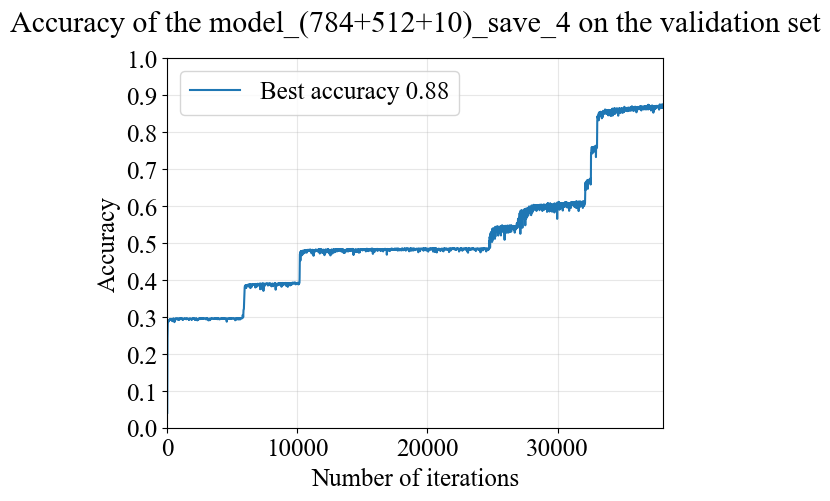

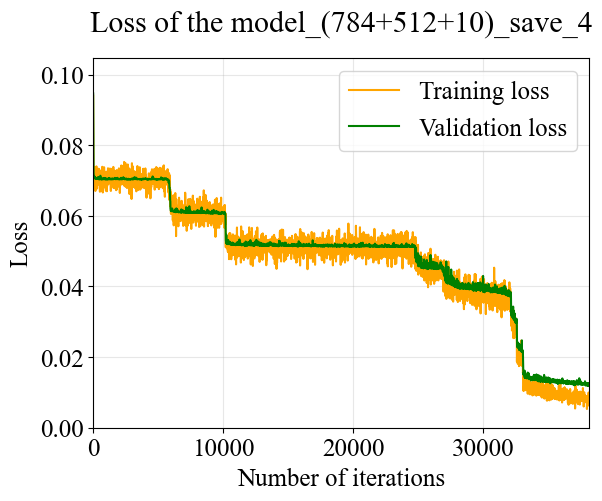

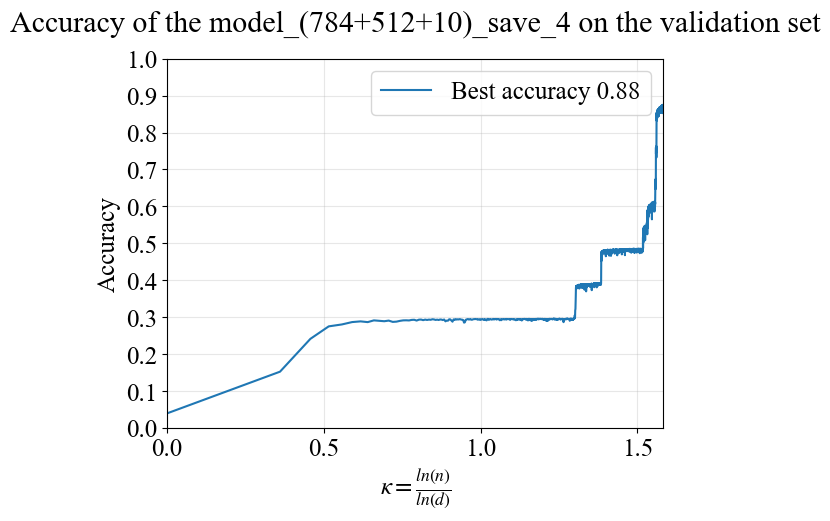

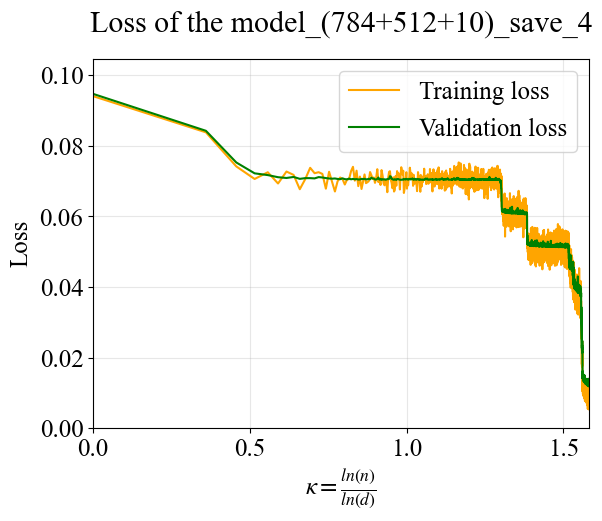

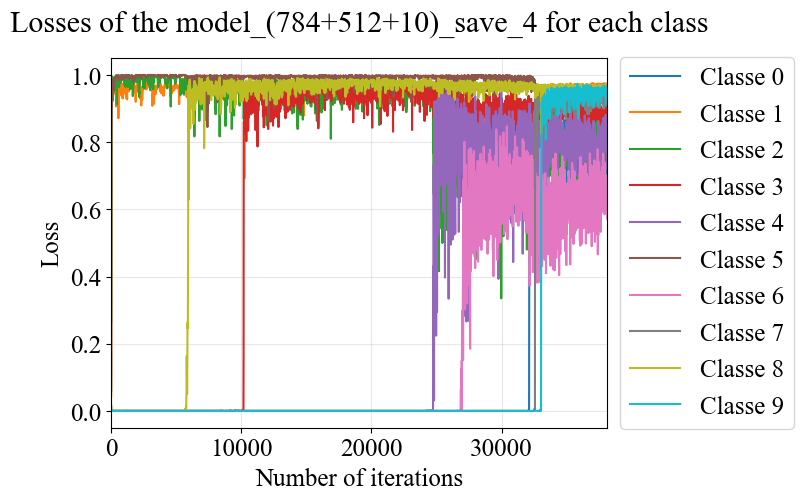

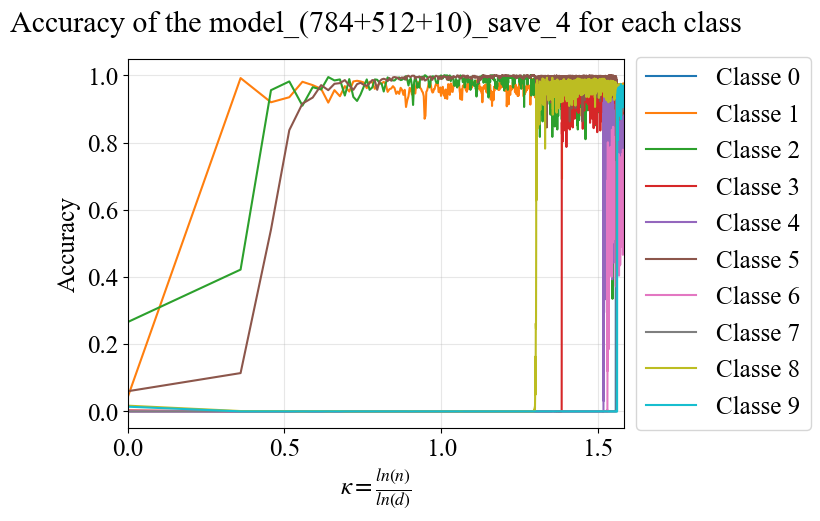

In [29]:
save = True

date = "05_05_25_"
if save :
    # Save the model
    model = model_2_layer
    model_name = "model_(784+512+10)_save_4"
    save_path = "Classifiers/" + date + model_name + "/"
    os.makedirs(save_path, exist_ok=True)
    torch.save(model , save_path + model_name + ".pt")


    # Save Architecture
    with open(save_path + "architecture.txt", "w", encoding="utf-8") as f:
        f.write(model.architecture + str(model.training_time))

    # Save performances of the model
    os.makedirs(save_path + "figures/", exist_ok=True) 
    # Plot accuracy = f(n)
    plt.plot(np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, len(model.accuracy_trajectory)*model.observation_rate)
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel("Number of iterations")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory)) 
    np.savetxt(save_path +"figures/accuracy_of_" + model_name + ".txt", data, delimiter =",", header="n,accuracy")
    plt.show() 
    
    # Plot training and validation loss = f(n)
    plt.plot(np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(np.linspace(0,len(model.validation_loss_trajectory)*model.observation_rate, len(model.validation_loss_trajectory)), model.validation_loss_trajectory, label="Validation loss", color = "green")
    plt.xlim(0, len(model.training_loss_trajectory)*model.observation_rate)
    plt.ylim(0, np.max([model.training_loss_trajectory, model.validation_loss_trajectory])+0.01)
    plt.xlabel("Number of iterations")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory))
    np.savetxt(save_path + "figures/loss_training_" + model_name + ".txt", data, delimiter=",", header="n, training_loss")
    plt.show()
    
    # Plot accuracy = f(kappa)
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.accuracy_trajectory)*model.observation_rate+1, len(model.accuracy_trajectory))]
    plt.plot(kappa, model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, np.max(kappa))
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((kappa, model.accuracy_trajectory))
    np.savetxt(save_path + "figures/kappa_accuracy_" + model_name + ".txt", data, delimiter=",", header="kappa, accuracy")
    plt.show()
    
    # Plot training and validation loss
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory))]
    plt.plot(kappa, model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(kappa, model.validation_loss_trajectory, label = "Validation loss", color = "green")
    plt.xlim(0, np.max(kappa))
    plt.ylim(0, np.max([model.training_loss_trajectory, model.validation_loss_trajectory])+0.01)
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".svg", bbox_inches='tight')
    data_training = np.column_stack((kappa, model.training_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_training_" + model_name + ".txt", data_training, delimiter=",", header="kappa, training_loss")
    data_validation = np.column_stack((kappa, model.validation_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_validation_" + model_name + ".txt", data_validation, delimiter=",", header="kappa, validation_loss")
    plt.show()
    
    if model.observation_by_class :
        for i in range(len(model.classes_accuracies_trajectories[0])) :
            plt.plot(np.linspace(1,len(model.classes_accuracies_trajectories)*model.observation_rate, len(model.classes_accuracies_trajectories)), np.array(model.classes_accuracies_trajectories)[:,i], label = 'Classe ' + str(i))
        plt.xlim(0, len(model.classes_accuracies_trajectories)*model.observation_rate)
        plt.xlabel('Number of iterations')  
        plt.ylabel("Loss")
        plt.grid(alpha=0.3)
        plt.title("Losses of the " + model_name + ' for each class', pad = 20)
        plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
        plt.savefig(save_path + "figures/Accuracy_of_the_" + model_name + "for_each_class.png", bbox_inches='tight')
        plt.savefig(save_path + "figures/Accuracy_of_the_" + model_name + "for_each_class.svg", bbox_inches='tight')
        data_validation = np.column_stack((np.linspace(1,len(model.classes_accuracies_trajectories)*model.observation_rate, len(model.classes_accuracies_trajectories)), np.array(model.classes_accuracies_trajectories)))
        np.savetxt(save_path + "figures/Accuracy_of_the_" + model_name + "for_each_class.txt", data_validation, delimiter=",", header="N_iter, Accuracy_by_class")
        plt.show()
        
        kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.classes_accuracies_trajectories)*model.observation_rate, len(model.classes_accuracies_trajectories))]
        for i in range(len(model.classes_accuracies_trajectories[0])) :
            plt.plot(kappa, np.array(model.classes_accuracies_trajectories)[:, i], label = 'Classe ' + str(i))
        plt.xlim(0, np.max(kappa))
        plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
        plt.ylabel("Accuracy")
        plt.grid(alpha=0.3)
        plt.title("Accuracy of the " + model_name + ' for each class', pad = 20)
        plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
        plt.savefig(save_path + "figures/kappa_accuracy_of_the_" + model_name + "for_each_class.png", bbox_inches='tight')
        plt.savefig(save_path + "figures/kappa_accuracy_of_the_" + model_name + "for_each_class.svg", bbox_inches='tight')
        data_validation = np.column_stack((kappa, np.array(model.classes_accuracies_trajectories)))
        np.savetxt(save_path + "figures/kappa_accuracy_of_the_" + model_name + "for_each_class.txt", data_validation, delimiter=",", header="kappa, Accuracy_by_class")
        plt.show()
else:
    print("No save")


In [21]:
print(np.shape(model.classes_accuracies_trajectories))
print(np.shape(np.array(model.classes_accuracies_trajectories)[:,1]))

(130, 5)
(130,)


0.001
tensor(0.8692)


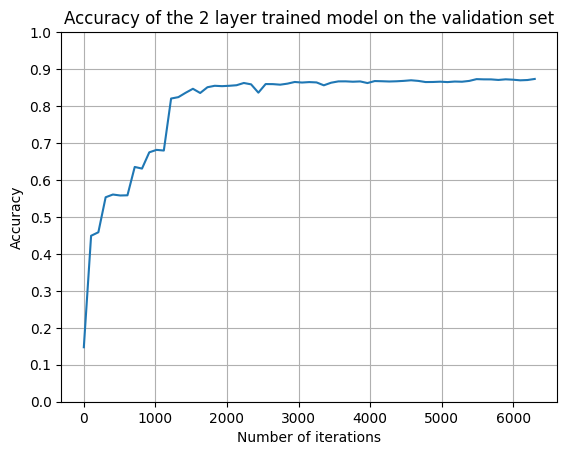

<Figure size 640x480 with 0 Axes>

In [ ]:
# Import model and plot performances

model_name = "model_2_layer_trained_save_1"
assessed_model = torch.load("datas/models/model_2_layer_save_1.pt", weights_only=False)

# Details of the model
print(assessed_model.architecture)

# Plots of performances
accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
plt.imshow(accuracy)
kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
plt.imshow(kappa_accuracy)
loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
plt.imshow(loss)
kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
plt.imshow(kappa_loss)
plt.show()

# Import datas
accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


In [ ]:
dtype = torch.float32

def ReLU(x):
    return torch.max(torch.tensor(0),x)

def ReLU_derivative(x):
    return (x>0).to(dtype)

def softmax_derivative(s):
    """
    s : Tensor de shape (n_batch, num_classes), déjà softmaxé
    Renvoie : Tensor de shape (n_batch, num_classes, num_classes) contenant la jacobienne de softmax pour chaque échantillon
    """
    n, C = s.shape
    jacobians = torch.zeros(n, C, C, dtype=s.dtype) # Initialisation du tenseur Jacobien (n_batch, num_classes, num_classes) => (i,j,k) = dérivée de softmax au logit j du ième batch par rapport au logit k du même batch
    for i in range(n):  # Pour chaque échantillon du batch, on calcule la jacobienne de softmax
        si = s[i].unsqueeze(1)  # shape (C, 1) # vecteur softmax(logits) pour la i-ème donnée du batch
        jacobians[i] = torch.diagflat(si) - torch.mm(si,si.t()) # calcul de la jacobienne (matrice des dérivées croisées) de softmax au point z_i = vect(logits_i) # shape (C, C) -> Indice du Jacobien : lignes, Indice des logits : colonnes
    return jacobians



class three_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,number_of_classes,lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, esp_init = 1, fraction_batch=0.01):
        """
        Constructor of the two-layer neural network class.
        """
        super(two_layer_NN,self).__init__()
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = esp_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.fraction_batch = fraction_batch
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(number_of_classes, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = esp_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        h2 = ReLU(z2) # # hidden neurons layer 2
        z3 = torch.mm(self.W3, h2.t() + self.b3)
        output = self.softmax(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, coef_iter = 1, lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=0.2, fraction_batch=1e-2, train_layer1=True, train_layer2=True, train_layer3=True):
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        kappa_max = 1 + coef_iter
        max_iter = self.input_dimension**(kappa_max)
        print("max_iter", max_iter)
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_minibatches = int(max_iter / self.fraction_batch) # Nombre de minibatches utilisés pour l'apprentissage de la première couche
        for i in range(N_minibatches):
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            # Suivi de l'apprentissage
            if i % 100 == 0:
                training_loss = torch.mean(0.5*(output - y_minibatch)**2, dim=0) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                overall_training_loss = torch.mean(training_loss,dim=0)
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2, dim=0)
                overall_validation_loss = torch.mean(validation_loss,dim=0)
                self.training_loss_trajectory.append(overall_training_loss.item())
                self.validation_loss_trajectory.append(overall_validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", overall_training_loss.item(), "Validation loss", overall_validation_loss.item(), "Accuracy", accuracy.item())
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            # Calcul des gradients
            grad_output = output - y_minibatch
            grad_z2 = torch.einsum('noz, no->nz', softmax_derivative(output), grad_output) # shape(n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h1 = torch.mm(grad_z2, self.W2)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0] # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = torch.mean(grad_z1, dim=0).unsqueeze(1) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0] # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = torch.mean(grad_z2, dim=0).unsqueeze(1)
            
            # Mise à jours des paramètres de la première couche
            self.W1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/self.eps_init**2 + self.reg1*self.W1) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
            self.b1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/self.eps_init**2 + self.reg1*self.b1)
            self.W2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/self.eps_init**2 +self.reg2*self.W2)
            self.b2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/self.eps_init**2 + self.reg2*self.b2)
        return "Training done"
   
